In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('D:\\damage_car_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\damage_car_dataset\car_damage_classification\training\00-damage\0001.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0002.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0003.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0004.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0005.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0006.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0007.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0008.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0009.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0010.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0011.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0012.JPEG
D:\damage_car_dataset\car_damage_classification\training\00-damage\0013.JPEG

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Conv2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-5
EPOCHS = 50
BS = 32

DIRECTORY = "D:\\damage_car_dataset/car_damage_classification/training/"
DIRECTORY2= "D:\\damage_car_dataset/car_damage_classification/validation/"
CATEGORIES = ["00-damage", "01-whole"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [5]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


for category in CATEGORIES:
    path = os.path.join(DIRECTORY2, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)
        
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [6]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


baseModel = DenseNet121(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [7]:
def squeeze_excite_block(filters,input):                      
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Reshape((1, filters))(se) 
    se = tf.keras.layers.Dense(filters//16, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([input, se])
    return se

In [10]:
headModel = baseModel.output
headModel = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(headModel)
headModel = squeeze_excite_block(32,headModel)
headModel = tf.keras.layers.AveragePooling2D(2)(headModel)        


headModel = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(headModel)
headModel = squeeze_excite_block(32,headModel)
headModel = tf.keras.layers.AveragePooling2D(2)(headModel)

headModel = tf.keras.layers.concatenate([tf.keras.layers.GlobalMaxPooling2D()(headModel), tf.keras.layers.GlobalAveragePooling2D()(headModel)])
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

 dense (Dense)                  (None, 1, 2)         66          ['reshape[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1, 32)        96          ['dense[0][0]']                  
                                                                                                  
 multiply (Multiply)            (None, 7, 7, 32)     0           ['conv2d[0][0]',                 
                                                                  'dense_1[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 3, 3, 32)    0           ['multiply[0][0]']               
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 

In [12]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

c:\users\aw347\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/50
57/57 [==============================] - 155s 741ms/step - loss: 0.6932 - accuracy: 0.5238 - val_loss: 0.6855 - val_accuracy: 0.6413
Epoch 2/50
57/57 [==============================] - 23s 394ms/step - loss: 0.6821 - accuracy: 0.6117 - val_loss: 0.6716 - val_accuracy: 0.7087
Epoch 3/50
57/57 [==============================] - 23s 397ms/step - loss: 0.6634 - accuracy: 0.6897 - val_loss: 0.6452 - val_accuracy: 0.7087
Epoch 4/50
57/57 [==============================] - 23s 393ms/step - loss: 0.6328 - accuracy: 0.7428 - val_loss: 0.6091 - val_accuracy: 0.7587
Epoch 5/50
57/57 [==============================] - 23s 396ms/step - loss: 0.5942 - accuracy: 0.7920 - val_loss: 0.5715 - val_accuracy: 0.7587
Epoch 6/50
57/57 [==============================] - 23s 393ms/step - loss: 0.5573 - accuracy: 0.7893 - val_loss: 0.5258 - val_accuracy: 0.7957
Epoch 7/50
57/57 [==============================] - 23s 393ms/step - loss: 0.5119 - accuracy: 0.8296 - val_loss: 0.4861 - val_accuracy: 0.813

In [14]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [15]:
predIdxs = np.argmax(predIdxs, axis=1)

In [16]:
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   00-damage       0.91      0.94      0.93       230
    01-whole       0.94      0.91      0.92       230

    accuracy                           0.92       460
   macro avg       0.92      0.92      0.92       460
weighted avg       0.92      0.92      0.92       460



In [17]:
model.save("DenseNet121_SE_detection.model", save_format="h5")

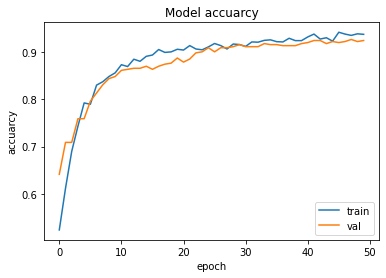

In [18]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuarcy')
plt.ylabel('accuarcy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='lower right')
plt.show()

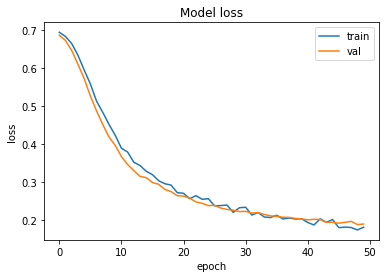

In [19]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

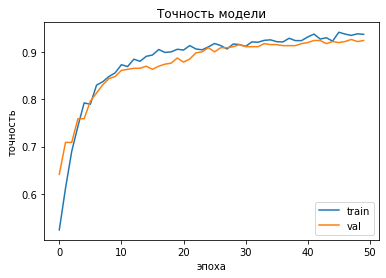

In [20]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('эпоха')
plt.legend(['train','val'], loc='lower right')
plt.show()

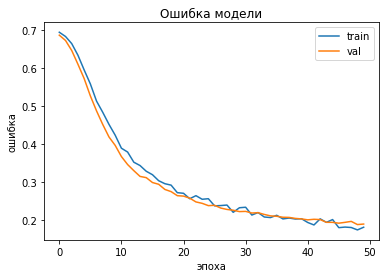

In [21]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Ошибка модели')
plt.ylabel('ошибка')
plt.xlabel('эпоха')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [22]:
model.save("DenseNet121_SE.h5")

In [1]:
from keras import models    
DenseNet = models.load_model("DenseNet121_SE.h5")

Car is not damaged: 0.98496664


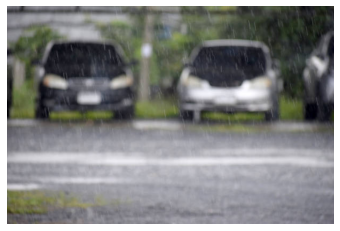

In [5]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/rain.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))

Car is damaged: 0.99892527


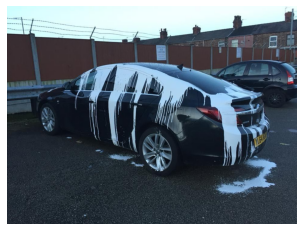

In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/138.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))

Car is damaged: 0.9996977


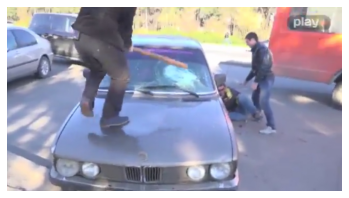

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/20.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))

Car is damaged: 0.99623775


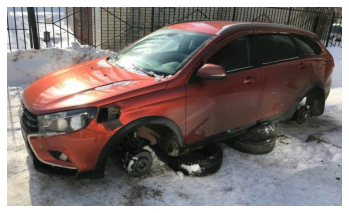

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/1.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))

Car is damaged: 0.9764756


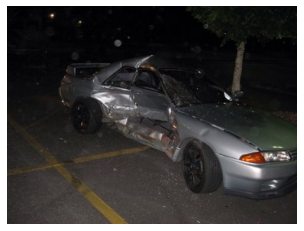

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/night7.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))

Car is damaged: 0.62258756


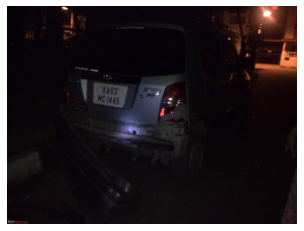

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/night_damage1.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))

Car is damaged: 0.6641948


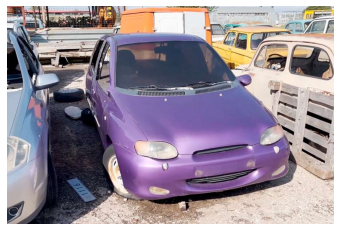

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/140.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))

Car is damaged: 0.99786985


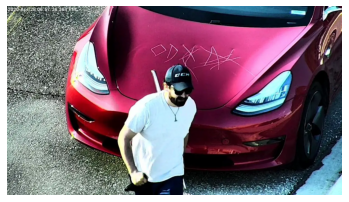

In [8]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/10.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "D:\\car_damage_classification/night4.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape(224,224,3)
img_array= img_array/255
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

prediction=DenseNet.predict(img_batch)

if prediction[0][0]<prediction[0][1]:
     print("Car is not damaged: "+str(prediction[0][1]))
else:
    print("Car is damaged: "+str(prediction[0][0]))